In [100]:
import pandas as pd
import numpy as np
import json
import re
from nltk import word_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
import html
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt
import seaborn as sns

In [101]:
harris_file = "harris_timeline.json"

with open(harris_file, 'r') as file:
    harris_data = json.load(file)

In [102]:
df_harris = pd.DataFrame([t['created_at'] for t in harris_data], columns=['create_time'])
df_harris['text'] = [t['text'] for t in harris_data]
df_harris['retweets'] = [t['retweet_count'] for t in harris_data]
df_harris['favorites'] = [t['favorite_count'] for t in harris_data]

In [103]:
df_harris.head()

,create_time,text,retweets,favorites
0,Thu Oct 22 00:41:00 +0000 2020,We're just days away from the end of the elect...,733,4221
1,Wed Oct 21 23:29:52 +0000 2020,545 children. \n\nThis is outrageous and a sta...,3100,17262
2,Wed Oct 21 22:51:39 +0000 2020,This is our moment to do something for our fam...,982,5514
3,Wed Oct 21 21:47:21 +0000 2020,.@BarackObama knows that the election is happe...,1621,9163
4,Wed Oct 21 20:21:01 +0000 2020,RT @JoeBiden: Tune in as @BarackObama sits dow...,4097,0


In [104]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to \\graddirs.cs.odu.edu\Gra
[nltk_data]     d\cs_mibra004\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to \\graddirs.cs.odu.edu\Grad\cs
[nltk_data]     _mibra004\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [105]:
import string


stop_words = set(stopwords.words('english'))

def text_cleanup(c):
    clean_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', c)))
    clean_noemoji = clean_unesc.encode('ascii', 'ignore').decode('ascii')
    wt = word_tokenize(clean_noemoji.lower())
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and (w.isalnum())]
    return ' '.join(wt_filt)

def sentim_polarity(s):
    return TextBlob(s).sentiment.polarity

def sentim_subject(s):
    return TextBlob(s).sentiment.subjectivity

In [106]:
df_harris['text_clean'] = df_harris['text'].apply(text_cleanup)
df_harris['polarity'] = df_harris['text_clean'].apply(sentim_polarity)
df_harris['subjectivity'] = df_harris['text_clean'].apply(sentim_subject)


In [107]:
df_harris_post = df_harris[['create_time', 'retweets', 'favorites']]

In [108]:
biden_time_list = pd.to_datetime(df_harris_post['create_time'], format='%a %b %d %H:%M:%S +0000 %Y')
df_harris_post = df_harris_post.assign(create_time=biden_time_list)
biden_hour_list = df_harris_post['create_time'].dt.strftime('%H')
df_harris_post = df_harris_post.assign(create_hour=biden_hour_list)
harris_post_avg = df_harris_post.groupby('create_hour').mean().round(2)

C:\Users\cs_mibra004\AppData\Local\Temp\ipykernel_5468\2448436999.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  harris_post_avg = df_harris_post.groupby('create_hour').mean().round(2)


In [109]:
harris_max_retweets = harris_post_avg.loc[:, 'retweets'].max()
harris_max_likes = harris_post_avg.loc[:, 'favorites'].max()
harris_post_avg['retweet_percent'] = (harris_post_avg['retweets'] / harris_max_retweets).round(2)
harris_post_avg['like_percent'] = (harris_post_avg['favorites'] / harris_max_likes).round(2)
harris_post_avg.head()

,retweets,favorites,retweet_percent,like_percent
create_hour,,,,
00,15823.29,32153.86,0.60,0.24
01,14325.94,80103.03,0.55,0.59
02,13629.10,73177.80,0.52,0.54
03,13693.00,99270.00,0.52,0.74
12,16020.00,134929.00,0.61,1.00


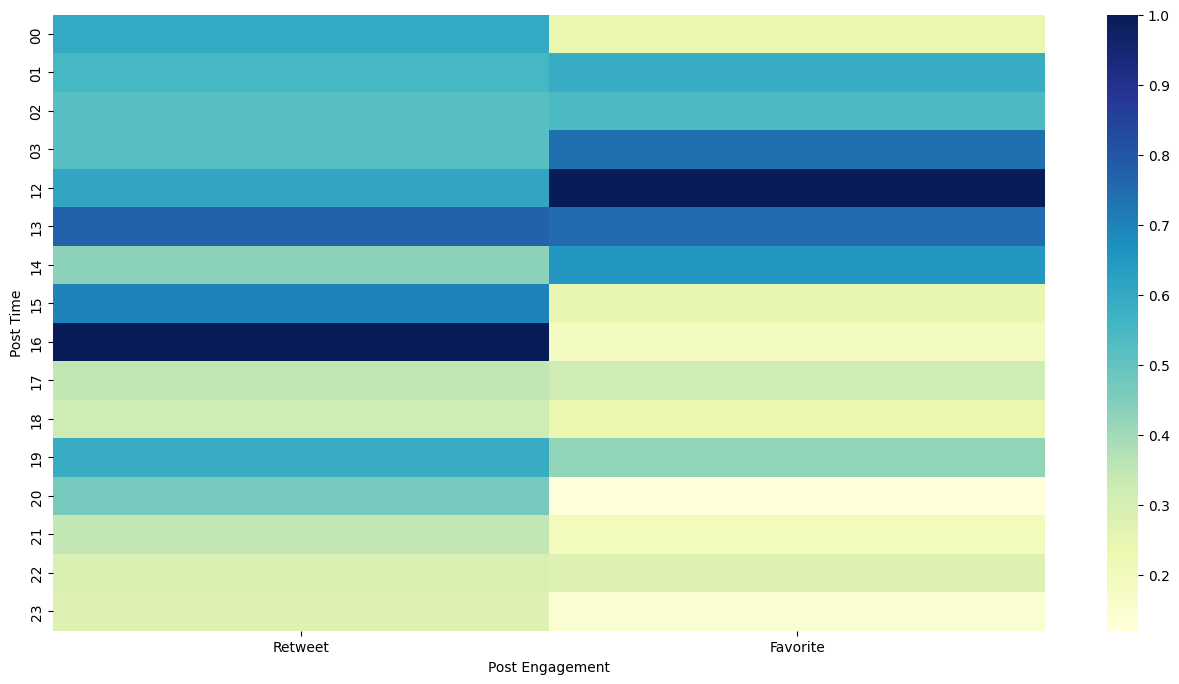

In [110]:
biden_post_heatmap = harris_post_avg[['retweet_percent', 'like_percent']]
plt.subplots(figsize=(16, 8))
g = sns.heatmap(biden_post_heatmap, cmap = 'YlGnBu')
g.set_xticklabels(['Retweet','Favorite'])
plt.xlabel('Post Engagement')
plt.ylabel('Post Time')
plt.show()

In [111]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    return "positive" if blob.sentiment.polarity > 0 else "negative" if blob.sentiment.polarity < 0 else "neutral"

df_harris['sentiment_2'] = df_harris['text_clean'].apply(analyze_sentiment)

In [112]:
df_harris['keywords'] = df_harris['text_clean'].apply(
    lambda x: "election" if "election" in x else "children" if "children" in x else "other"
)

In [113]:
df_harris['create_time'] = pd.to_datetime(df_harris['create_time']).dt.tz_localize(None) 

In [81]:
trend_data = df_harris.groupby(['create_time', 'keywords']).size().reset_index(name='frequency')
trend_data['ds'] = pd.to_datetime(trend_data['create_time'])
trend_data['y'] = trend_data['frequency']

In [114]:
from prophet import Prophet
model = Prophet()
model.fit(trend_data[['ds', 'y']])
future = model.make_future_dataframe(periods=14)  # Extend prediction to 2 weeks
forecast = model.predict(future)

00:55:20 - cmdstanpy - INFO - Chain [1] start processing
00:55:20 - cmdstanpy - INFO - Chain [1] done processing


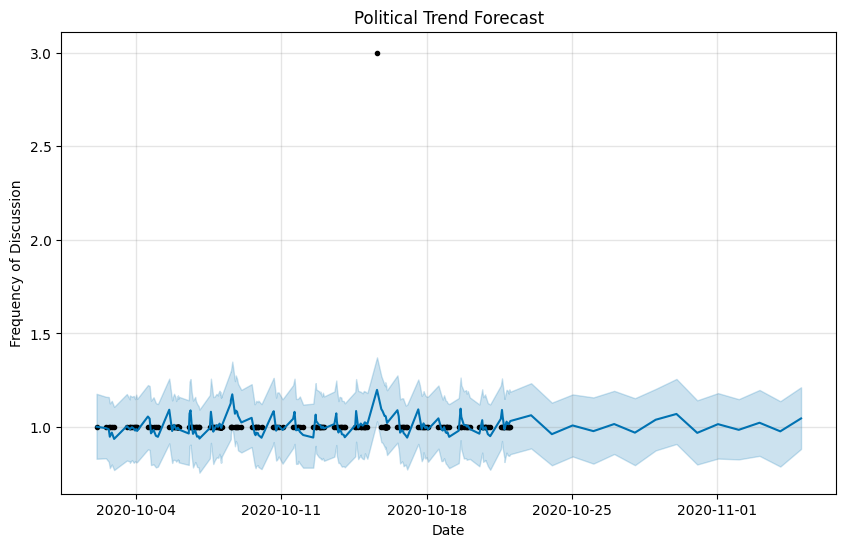

In [115]:
fig, ax = plt.subplots(figsize=(10, 6))
model.plot(forecast, ax=ax)
plt.title("Political Trend Forecast")
plt.xlabel("Date")
plt.ylabel("Frequency of Discussion")
plt.show()

In [89]:
biden_file = "biden_timeline.json"
trump_file = "trump_timeline.json"

with open(biden_file, 'r') as file:
    biden_data = json.load(file)

with open(trump_file, 'r') as file:
    trump_data = json.load(file)

In [90]:
df_trump = pd.json_normalize(trump_data)
df_trump = df_trump[['created_at', 'text', 'retweet_count', 'favorite_count']]
df_trump = df_trump.rename(columns={"created_at": "create_time", 'retweet_count':'retweets', 'favorite_count':'favorites'})

trump_tokens = [word_tokenize(m) for m in df_trump['text']]
trump_tokens_cleaned = [[q for q in p if q.isalpha()] for p in trump_tokens]
trump_token_list = []
for n in range(len(trump_tokens_cleaned)):
     trump_token_list.append(len(trump_tokens_cleaned[n]))
df_trump['word_tokens'] = trump_token_list

In [94]:
df_biden = pd.DataFrame([t['created_at'] for t in biden_data], columns=['create_time'])
df_biden['text'] = [t['text'] for t in biden_data]
df_biden['retweets'] = [t['retweet_count'] for t in biden_data]
df_biden['favorites'] = [t['favorite_count'] for t in biden_data]

biden_tokens = [word_tokenize(m) for m in df_biden['text']]
biden_tokens_cleaned = [[q for q in p if q.isalpha()] for p in biden_tokens]
biden_token_list = []
for n in range(len(biden_tokens_cleaned)):
     biden_token_list.append(len(biden_tokens_cleaned[n]))
df_biden['word_tokens'] = biden_token_list

In [91]:
df_trump.head()

,create_time,text,retweets,favorites,word_tokens
0,Wed Oct 21 22:41:26 +0000 2020,Exclusive: Forgotten by Obama-Biden Auto Bailo...,6171,18497,17
1,Wed Oct 21 22:41:19 +0000 2020,Multiple Pro-Trump Demonstrations Planned in C...,6555,26744,9
2,Wed Oct 21 22:33:24 +0000 2020,Pennsylvania Trump Voters Show Passion: ‘He‘s ...,6033,24106,20
3,Wed Oct 21 22:31:37 +0000 2020,WSJ Editorial Board: Joe Biden Must Answer Que...,9732,29527,16
4,Wed Oct 21 21:57:10 +0000 2020,See you soon North Carolina! https://t.co/MWfy...,6711,33761,7


In [92]:
avg_favorites_trump = round(df_trump.loc[df_trump['favorites']!=0, 'favorites'].mean(), 2)
df_trump=df_trump.replace({'favorites': {0: avg_favorites_trump}})

In [93]:
stop_words = set(stopwords.words('english'))

def text_cleanup(c):
    clean_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', c)))
    clean_noemoji = clean_unesc.encode('ascii', 'ignore').decode('ascii')
    wt = word_tokenize(clean_noemoji.lower())
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and (w.isalnum())]
    return ' '.join(wt_filt)

def sentim_polarity(s):
    return TextBlob(s).sentiment.polarity

def sentim_subject(s):
    return TextBlob(s).sentiment.subjectivity

In [95]:
df_biden['text_clean'] = df_biden['text'].apply(text_cleanup)

In [96]:
avg_favorites_biden = round(df_biden.loc[df_biden['favorites']!=0, 'favorites'].mean(), 2)
df_biden=df_biden.replace({'favorites': {0: avg_favorites_biden}})

In [97]:
df_biden['polarity'] = df_biden['text_clean'].apply(sentim_polarity)
df_biden['subjectivity'] = df_biden['text_clean'].apply(sentim_subject)

In [98]:
df_trump['text_clean'] = df_trump['text'].apply(text_cleanup)
df_trump['polarity'] = df_trump['text_clean'].apply(sentim_polarity)
df_trump['subjectivity'] = df_trump['text_clean'].apply(sentim_subject)

In [99]:
df_biden_post = df_biden[['create_time', 'retweets', 'favorites']]
df_biden_post

,create_time,retweets,favorites
0,Thu Oct 22 00:30:00 +0000 2020,1181,4677.00
1,Wed Oct 21 23:50:00 +0000 2020,2921,19363.00
2,Wed Oct 21 23:15:00 +0000 2020,10607,74966.00
3,Wed Oct 21 21:47:08 +0000 2020,4454,28721.00
4,Wed Oct 21 21:05:00 +0000 2020,14701,84864.00
...,...,...,...
195,Fri Oct 09 21:25:20 +0000 2020,2846,12931.00
196,Fri Oct 09 20:05:00 +0000 2020,18085,99806.00
197,Fri Oct 09 18:52:00 +0000 2020,45574,295094.00
198,Fri Oct 09 18:27:16 +0000 2020,559,106634.55


In [127]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR))]

In [128]:
df_trump = remove_outliers_iqr(df_trump, 'retweets')
df_trump = remove_outliers_iqr(df_trump, 'favorites')
df_biden = remove_outliers_iqr(df_biden, 'retweets')
df_biden = remove_outliers_iqr(df_biden, 'favorites')

In [129]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    sentiment = "positive" if polarity > 0 else "negative" if polarity < 0 else "neutral"
    return polarity, subjectivity, sentiment

00:24:19 - cmdstanpy - INFO - Chain [1] start processing
00:24:19 - cmdstanpy - INFO - Chain [1] done processing


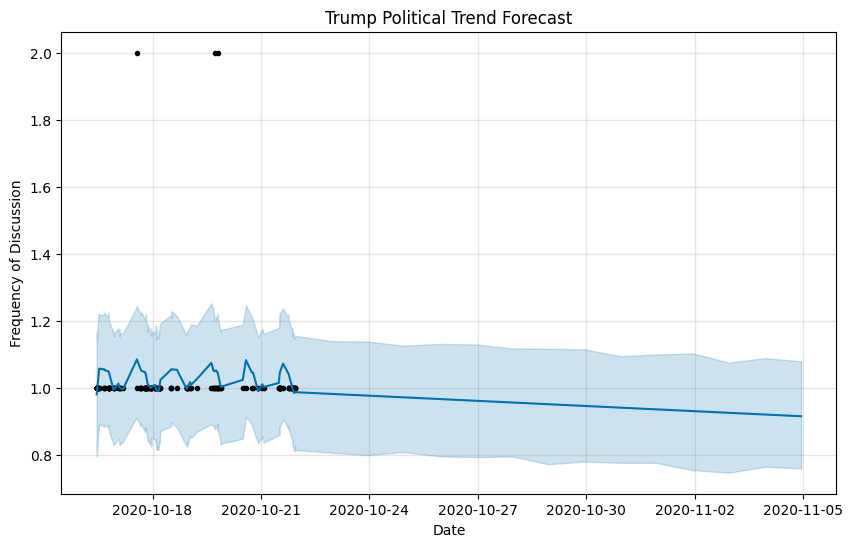

00:24:19 - cmdstanpy - INFO - Chain [1] start processing
00:24:19 - cmdstanpy - INFO - Chain [1] done processing


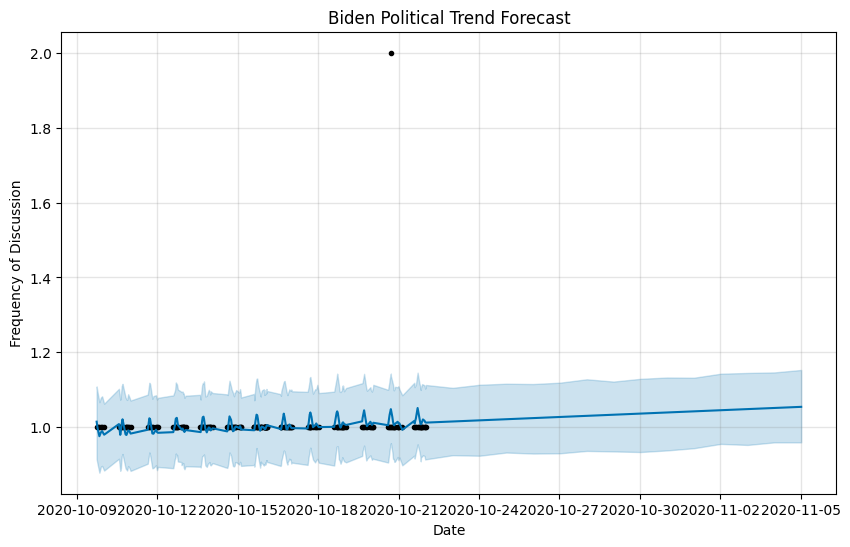

In [130]:
for data, president in [(df_trump, "Trump"), (df_biden, "Biden")]:
    # Ensure datetime format and remove timezone
    data['create_time'] = pd.to_datetime(data['create_time']).dt.tz_localize(None)
    
    # Apply sentiment analysis
    data[['polarity', 'subjectivity', 'sentiment_2']] = data['text'].apply(
        lambda x: pd.Series(analyze_sentiment(x))
    )
    
    # Extract keywords
    data['keywords'] = data['text_clean'].apply(
        lambda x: "election" if "election" in x else "policy" if "policy" in x else "other"
    )

    trend_data = data.groupby(['create_time', 'keywords']).size().reset_index(name='frequency')
    trend_data['ds'] = trend_data['create_time']
    trend_data['y'] = trend_data['frequency']


    model = Prophet()
    model.fit(trend_data[['ds', 'y']])
    future = model.make_future_dataframe(periods=14)
    forecast = model.predict(future)

    fig, ax = plt.subplots(figsize=(10, 6))
    model.plot(forecast, ax=ax)
    plt.title(f"{president} Political Trend Forecast")
    plt.xlabel("Date")
    plt.ylabel("Frequency of Discussion")
    plt.show()


In [105]:
df_trump['sentiment_2'].value_counts()

positive    87
neutral     85
negative    28
Name: sentiment_2, dtype: int64

In [106]:
df_biden['sentiment_2'].value_counts()

neutral     87
positive    82
negative    31
Name: sentiment_2, dtype: int64

In [107]:
df_harris['sentiment_2'].value_counts()

neutral     99
positive    79
negative    22
Name: sentiment_2, dtype: int64

In [109]:
pence_file = "pence_timeline.json"

with open(pence_file, 'r') as file:
    pence_data = json.load(file)

In [110]:
df_pence = pd.DataFrame([t['created_at'] for t in pence_data], columns=['create_time'])
df_pence['text'] = [t['text'] for t in pence_data]
df_pence['retweets'] = [t['retweet_count'] for t in pence_data]
df_pence['favorites'] = [t['favorite_count'] for t in pence_data]

pence_tokens = [word_tokenize(m) for m in df_pence['text']]
pence_tokens_cleaned = [[q for q in p if q.isalpha()] for p in pence_tokens]
pence_token_list = []
for n in range(len(pence_tokens_cleaned)):
     pence_token_list.append(len(pence_tokens_cleaned[n]))
df_pence['word_tokens'] = pence_token_list

In [111]:
df_pence['text_clean'] = df_pence['text'].apply(text_cleanup)
df_pence['polarity'] = df_pence['text_clean'].apply(sentim_polarity)
df_pence['subjectivity'] = df_pence['text_clean'].apply(sentim_subject)
df_pence

,create_time,text,retweets,favorites,word_tokens,text_clean,polarity,subjectivity
0,Thu Oct 22 00:49:33 +0000 2020,RT @realDonaldTrump: THANK YOU NORTH CAROLINA!...,3614,0,7,rt realdonaldtrump thank north carolina,0.000000,0.000000
1,Thu Oct 22 00:49:24 +0000 2020,RT @realDonaldTrump: The Radical Biden-Harris ...,2819,0,19,rt realdonaldtrump radical agenda projected sl...,-0.166667,0.500000
2,Thu Oct 22 00:37:55 +0000 2020,"RT @KarenPence: Great day in Mount Joy, Pennsy...",253,0,20,rt karenpence great day mount joy pennsylvania...,0.800000,0.475000
3,Thu Oct 22 00:36:22 +0000 2020,RT @TeamTrump: President @realDonaldTrump: The...,657,0,20,rt teamtrump president realdonaldtrump first t...,0.250000,0.333333
4,Thu Oct 22 00:36:11 +0000 2020,"RT @TrumpWarRoom: Claim: “On day one, Joe Bide...",3297,0,17,rt trumpwarroom claim day one joe bidens going...,0.350000,0.650000
...,...,...,...,...,...,...,...,...
194,Thu Oct 15 02:12:21 +0000 2020,RT @realDonaldTrump: THANK YOU IOWA! #MAGA htt...,12713,0,7,rt realdonaldtrump thank iowa maga,0.000000,0.000000
195,Thu Oct 15 02:12:07 +0000 2020,RT @SecondLady: Informative meeting with senio...,553,0,16,rt secondlady informative meeting senior milit...,-0.100000,0.100000
196,Thu Oct 15 01:45:48 +0000 2020,RT @SecondLady: To our Nation's #MilitarySpous...,610,0,21,rt secondlady nation militaryspouses incredibl...,0.550000,0.550000
197,Wed Oct 14 23:55:28 +0000 2020,RT @TeamTrump: LIVE: President Donald Trump in...,2408,0,15,rt teamtrump live president donald trump des m...,0.136364,0.500000


18:42:02 - cmdstanpy - INFO - Chain [1] start processing
18:42:02 - cmdstanpy - INFO - Chain [1] done processing


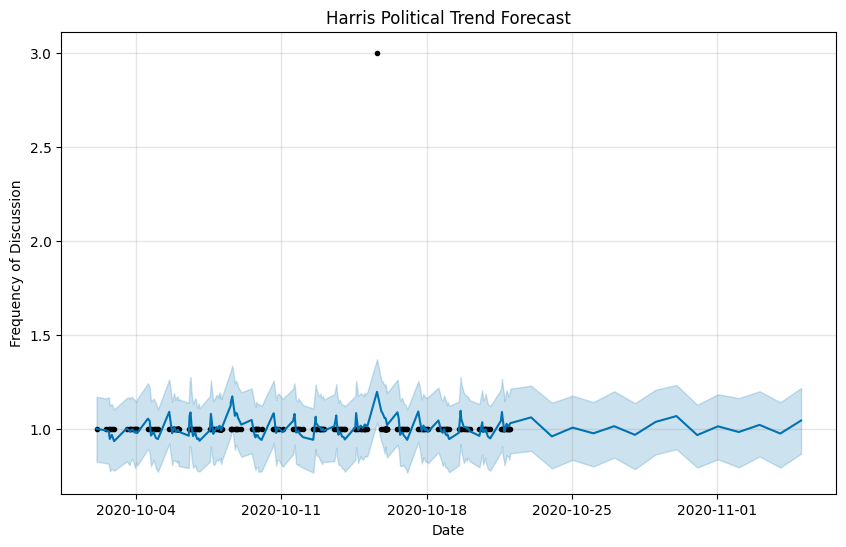

18:42:03 - cmdstanpy - INFO - Chain [1] start processing
18:42:03 - cmdstanpy - INFO - Chain [1] done processing


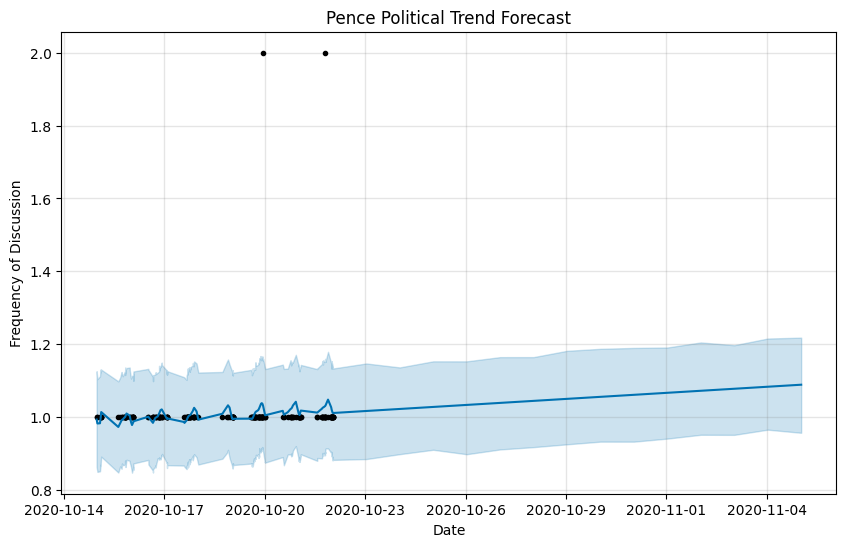

In [112]:
for data, president in [(df_harris, "Harris"), (df_pence, "Pence")]:
    # Ensure datetime format and remove timezone
    data['create_time'] = pd.to_datetime(data['create_time']).dt.tz_localize(None)
    
    # Apply sentiment analysis
    data[['polarity', 'subjectivity', 'sentiment_2']] = data['text'].apply(
        lambda x: pd.Series(analyze_sentiment(x))
    )
    
    # Extract keywords
    data['keywords'] = data['text_clean'].apply(
        lambda x: "election" if "election" in x else "policy" if "policy" in x else "other"
    )

    # Group and prepare data for Prophet model
    trend_data = data.groupby(['create_time', 'keywords']).size().reset_index(name='frequency')
    trend_data['ds'] = trend_data['create_time']
    trend_data['y'] = trend_data['frequency']
    
    # Train the model and make future predictions
    model = Prophet()
    model.fit(trend_data[['ds', 'y']])
    future = model.make_future_dataframe(periods=14)
    forecast = model.predict(future)
    
    # Plotting forecast
    fig, ax = plt.subplots(figsize=(10, 6))
    model.plot(forecast, ax=ax)
    plt.title(f"{president} Political Trend Forecast")
    plt.xlabel("Date")
    plt.ylabel("Frequency of Discussion")
    plt.show()

In [113]:
df_pence['sentiment_2'].value_counts()

positive    94
neutral     93
negative    12
Name: sentiment_2, dtype: int64

In [116]:
trump_sentiment_counts = df_trump['sentiment_2'].value_counts()
biden_sentiment_counts = df_biden['sentiment_2'].value_counts()

In [117]:
sentiment_df = pd.DataFrame({
    'Trump': trump_sentiment_counts,
    'Biden': biden_sentiment_counts
}).fillna(0)

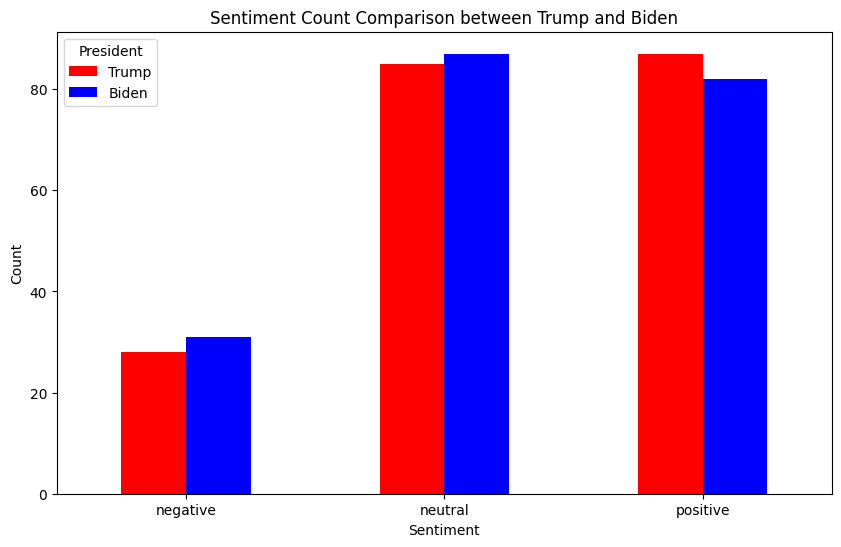

In [118]:
sentiment_df.plot(kind='bar', figsize=(10, 6), color=['red', 'blue'])
plt.title("Sentiment Count Comparison between Trump and Biden")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="President")
plt.show()

In [119]:
harris_sentiment_counts = df_harris['sentiment_2'].value_counts()
pence_sentiment_counts = df_pence['sentiment_2'].value_counts()

In [120]:
sentiment_df_1 = pd.DataFrame({
    'Harris': harris_sentiment_counts,
    'Pence': pence_sentiment_counts
}).fillna(0)

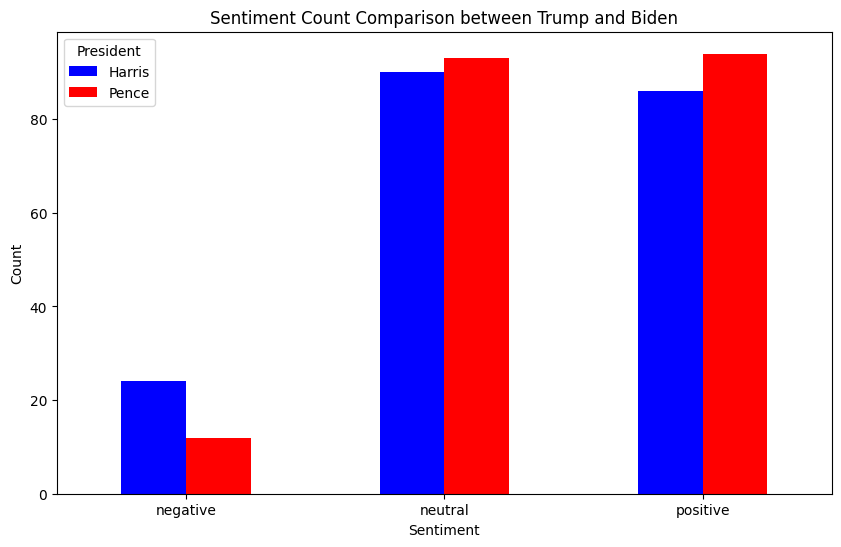

In [122]:
sentiment_df_1.plot(kind='bar', figsize=(10, 6), color=['blue', 'red'])
plt.title("Sentiment Count Comparison between Trump and Biden")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="President")
plt.show()